<h1>
<center>Adaboost Regression & Sector Rotation</center>
</h1>

# Packages and Data

In [1]:
import pandas as pd
import numpy as np
import yfinance as yahooFinance
from yahoofinancials import YahooFinancials
from fredapi import Fred
import datetime as datetime
import matplotlib.pyplot as plt

We first import the close prices of ETFs for each sector.

In [2]:
def import_fin(ticker):
    data = pd.DataFrame(YahooFinancials(ticker).get_historical_price_data(start_date='1901-01-01',
                                                                    end_date='2022-06-30',
                                                                    time_interval='daily')[ticker]['prices']).drop('date', axis=1).set_index('formatted_date')
    price = data['close']
    price.index = pd.to_datetime(price.index)
    
    return price

vnq = import_fin("VNQ")
xlk = import_fin("XLK")
xlf = import_fin("XLF")
xlv = import_fin("XLV")
xle = import_fin("XLE")
xly = import_fin("XLY")
xli = import_fin("XLI")
xlc = import_fin("XLC")
xlp = import_fin("XLP")
xlu = import_fin("XLU")
xlb = import_fin("XLB")

We will use the prices over the last 10 days to perform the prediction. Therefore, we need to have a script that transform it into this tructure. The following script will generate an input matrix (prices over the last 10 days) and an output vector (the target price for the prediction).

In [3]:
def ts_split(ts, feature_steps=10, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return X, y

In [4]:
X_vnq, y_vnq = ts_split(vnq)
X_xlk, y_xlk = ts_split(xlk)
X_xlf, y_xlf = ts_split(xlf)
X_xlv, y_xlv = ts_split(xlv)
X_xle, y_xle = ts_split(xle)
X_xly, y_xly = ts_split(xly)
X_xli, y_xli = ts_split(xli)
X_xlc, y_xlc = ts_split(xlc)
X_xlp, y_xlp = ts_split(xlp)
X_xlu, y_xlu = ts_split(xlu)
X_xlb, y_xlb = ts_split(xlb)

Now, we also want to split it into train and test sets for each ETF.

In [5]:
n = round(len(xlk)/2)
X_vnq_train, y_vnq_train = X_vnq[:round(len(vnq)/2)], y_vnq[:round(len(vnq)/2)]
X_xlk_train, y_xlk_train = X_xlk[:n], y_xlk[:n]
X_xlf_train, y_xlf_train = X_xlf[:n], y_xlf[:n]
X_xlv_train, y_xlv_train = X_xlv[:n], y_xlv[:n]
X_xle_train, y_xle_train = X_xle[:n], y_xle[:n]
X_xly_train, y_xly_train = X_xly[:n], y_xly[:n]
X_xli_train, y_xli_train = X_xli[:n], y_xli[:n]
X_xlc_train, y_xlc_train = X_xlc[:round(len(xlc)/2)], y_xlc[:round(len(xlc)/2)]
X_xlp_train, y_xlp_train = X_xlp[:n], y_xlp[:n]
X_xlu_train, y_xlu_train = X_xlu[:n], y_xlu[:n]
X_xlb_train, y_xlb_train = X_xlb[:n], y_xlb[:n]

X_vnq_test, y_vnq_test = X_vnq[round(len(vnq)/2):], y_vnq[round(len(vnq)/2):]
X_xlk_test, y_xlk_test = X_xlk[n:], y_xlk[n:]
X_xlf_test, y_xlf_test = X_xlf[n:], y_xlf[n:]
X_xlv_test, y_xlv_test = X_xlv[n:], y_xlv[n:]
X_xle_test, y_xle_test = X_xle[n:], y_xle[n:]
X_xly_test, y_xly_test = X_xly[n:], y_xly[n:]
X_xli_test, y_xli_test = X_xli[n:], y_xli[n:]
X_xlc_test, y_xlc_test = X_xlc[round(len(xlc)/2):], y_xlc[round(len(xlc)/2):]
X_xlp_test, y_xlp_test = X_xlp[n:], y_xlp[n:]
X_xlu_test, y_xlu_test = X_xlu[n:], y_xlu[n:]
X_xlb_test, y_xlb_test = X_xlb[n:], y_xlb[n:]

## Predicting Prices Using Adaboost Regressor

The following script will perform the prediction given the optimal hyperparameter.

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt

def compute_grd(X, X_train, y_train, y_test, md, n_est, lr, date, ticker):
    model = GradientBoostingRegressor(n_estimators=n_est, max_depth=md ,learning_rate=lr, random_state=0)
    model.fit(X_train, y_train)
    y_pred = pd.DataFrame(model.predict(X)).squeeze()
    y_pred.index = pd.to_datetime(date[-len(y_pred):])
    y_test = pd.DataFrame(y_test)
    y_test.index = date[-len(y_test):]
    y_pred_plot = y_pred[y_test.index]
    
    plt.plot(y_pred_plot, label="Prediction")
    plt.plot(y_test, label="Actual")
    plt.title(ticker)
    plt.legend()
    plt.show()
      
    return y_pred

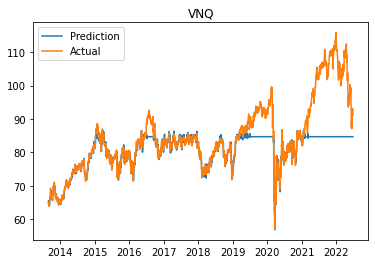

In [7]:
vnq_pred = compute_grd(X_vnq, X_vnq_train, y_vnq_train.ravel(), y_vnq_test.ravel(), 5, 54, 0.2, vnq.index, "VNQ")

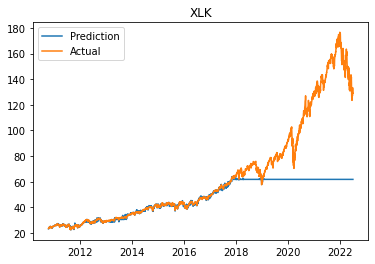

In [8]:
xlk_pred = compute_grd(X_xlk, X_xlk_train, y_xlk_train.ravel(), y_xlk_test.ravel(), 5, 80, 0.6, xlk.index, "XLK")

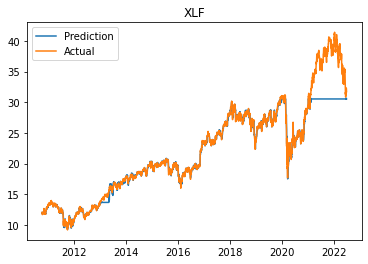

In [9]:
xlf_pred = compute_grd(X_xlf, X_xlf_train, y_xlf_train.ravel(), y_xlf_test.ravel(), 5, 56, 0.2, xlf.index, "XLF")

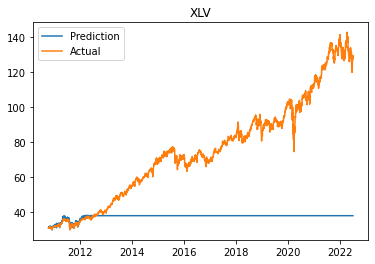

In [10]:
xlv_pred = compute_grd(X_xlv, X_xlv_train, y_xlv_train.ravel(), y_xlv_test.ravel(), 29, 1, 1.2, xlv.index, "XLV")

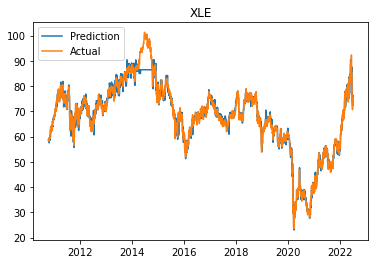

In [11]:
xle_pred = compute_grd(X_xle, X_xle_train, y_xle_train.ravel(), y_xle_test.ravel(), 11, 50, 0.4, xle.index, "XLE")

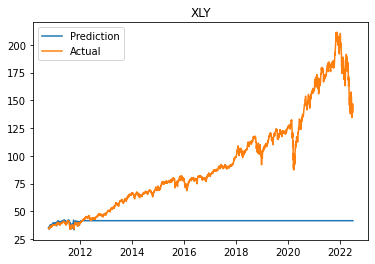

In [12]:
xly_pred = compute_grd(X_xly, X_xly_train, y_xly_train.ravel(), y_xly_test.ravel(), 15, 9, 1.8, xly.index, "XLY")

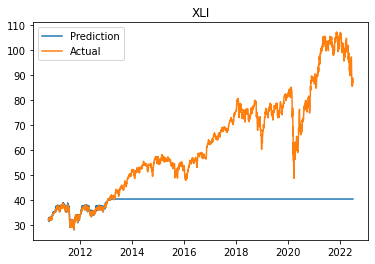

In [13]:
xli_pred = compute_grd(X_xli, X_xli_train, y_xli_train.ravel(), y_xli_test.ravel(), 1, 70, 1.8, xli.index, "XLI")

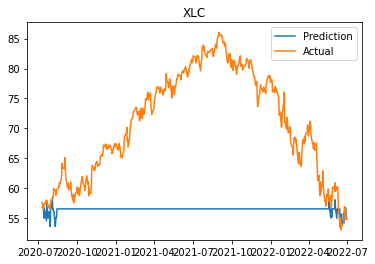

In [14]:
xlc_pred = compute_grd(X_xlc, X_xlc_train, y_xlc_train.ravel(), y_xlc_test.ravel(), 1, 70, 1, xlc.index, "XLC")

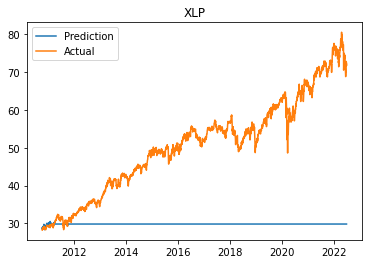

In [15]:
xlp_pred = compute_grd(X_xlp, X_xlp_train, y_xlp_train.ravel(), y_xlp_test.ravel(), 37, 9, 1.8, xlp.index, "XLP")

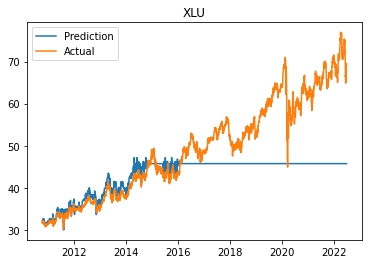

In [16]:
xlu_pred = compute_grd(X_xlu, X_xlu_train, y_xlu_train.ravel(), y_xlu_test.ravel(), 7, 1, 1.2, xlu.index, "XLU")

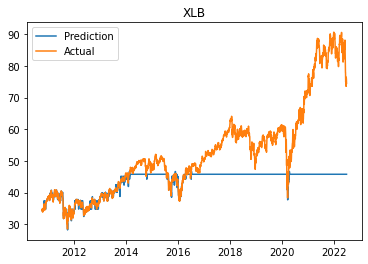

In [17]:
xlb_pred = compute_grd(X_xlb, X_xlb_train, y_xlb_train.ravel(), y_xlb_test.ravel(), 1, 90, 1.4, xlb.index, "XLB")

Overall, even after spending a lot of time tuning the hyperparameters, the result is not quite sucessful as expected.

# Sector Rotation

Throughout this process, we will consider and adjust the portfolio monthly. Thata is, we will ignore the changes in the middle of the month and consider the information of the prices at the end of the month. The following code will be used to extract the last trading day of each month.

In [18]:
def extract(months):
  ind = []
  for i in range(1,len(months)):
    if months[i-1] != months[i]:
      ind.append(i-1)
  ind = np.array(ind)
  return ind

In [19]:
ETF_list = [vnq,xlk,xlf,xlv,xle,xly,xli,xlc,xlp,xlu,xlb]
ETF = []
for i in range(len(ETF_list)):
    ETF.append(ETF_list[i][extract(ETF_list[i].index.month)])

The following table shows the price of each ETF at the end of each month. Note that NaN's might exist because the late inception.

In [20]:
name_list = ["vnq", "xlk","xlf", "xlv", "xle", "xly", "xli", "xlc", "xlp", "xlu", "xlb"]
table1 = pd.DataFrame(ETF).T
table1.columns = [k.upper() for k in name_list]
table1

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1998-12-31,NaN,32.625000,19.039398,26.000000,23.343750,26.125000,24.562500,NaN,27.156250,30.234375,21.921875
1999-01-29,NaN,37.812500,19.369415,27.250000,21.812500,27.468750,24.296875,NaN,26.796875,29.484375,21.109375
1999-02-26,NaN,34.062500,19.674046,27.281250,21.625000,27.296875,24.515625,NaN,26.515625,28.671875,21.437500
1999-03-31,NaN,36.593750,20.257919,28.000000,24.593750,28.593750,24.937500,NaN,26.437500,26.687500,21.750000
1999-04-30,NaN,36.812500,21.679529,29.000000,28.234375,29.343750,28.687500,NaN,25.515625,29.265625,27.125000
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,106.239998,161.970001,39.060001,131.229996,65.919998,184.949997,100.739998,73.949997,75.970001,69.250000,84.449997
2022-02-28,102.540001,154.070007,38.520000,129.960007,70.580002,177.429993,99.889999,68.449997,74.900002,67.930000,83.379997
2022-03-31,108.370003,158.929993,38.320000,136.990005,76.440002,185.000000,102.980003,68.779999,75.889999,74.459999,88.150002


In [21]:
returns = pd.DataFrame.diff(table1)/table1.shift()
returns

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1998-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-29,NaN,0.159004,0.017333,0.048077,-0.065596,0.051435,-0.010814,NaN,-0.013234,-0.024806,-0.037063
1999-02-26,NaN,-0.099174,0.015727,0.001147,-0.008596,-0.006257,0.009003,NaN,-0.010496,-0.027557,0.015544
1999-03-31,NaN,0.074312,0.029677,0.026346,0.137283,0.047510,0.017208,NaN,-0.002946,-0.069210,0.014577
1999-04-30,NaN,0.005978,0.070176,0.035714,0.148030,0.026230,0.150376,NaN,-0.034870,0.096604,0.247126
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,-0.084217,-0.068442,0.000256,-0.068564,0.187748,-0.095334,-0.047916,-0.048018,-0.014784,-0.032551,-0.067984
2022-02-28,-0.034827,-0.048774,-0.013825,-0.009678,0.070692,-0.040660,-0.008438,-0.074375,-0.014085,-0.019061,-0.012670
2022-03-31,0.056856,0.031544,-0.005192,0.054094,0.083026,0.042665,0.030934,0.004821,0.013218,0.096128,0.057208


Now, we will consider the predicted prices and returns.

In [22]:
date = xlc_pred.index

Pred_list = [vnq_pred.squeeze(), xlk_pred.squeeze(),xlf_pred.squeeze(),xlv_pred.squeeze(),xle_pred.squeeze(),
             xly_pred.squeeze(),xli_pred.squeeze(),xlc_pred.squeeze(),xlp_pred.squeeze(),xlu_pred.squeeze(),
             xlb_pred.squeeze()]
predict = []
for i in range(len(Pred_list)):
    predict.append(Pred_list[i][extract(Pred_list[i].index.month)])

The following table shows the predicted price at the end of each month.

In [23]:
table2 = pd.DataFrame(predict).T
table2.columns = [k.upper() for k in name_list]
table2

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-01-29,NaN,37.772674,18.891828,26.758757,21.814038,27.176813,24.502371,NaN,27.122223,29.669427,21.017871
1999-02-26,NaN,34.530400,19.316651,26.796257,21.627067,26.940663,24.502371,NaN,26.803225,28.396423,21.017871
1999-03-31,NaN,36.658988,20.456665,27.658757,24.598393,28.448453,25.298710,NaN,26.714614,26.043291,22.093090
1999-04-30,NaN,36.715240,21.919814,28.858757,28.234613,29.311175,29.298394,NaN,25.669007,29.669427,27.294713
1999-05-28,NaN,36.711312,20.236278,27.790007,27.622162,27.800335,28.157761,NaN,25.367730,29.669427,25.811334
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,84.699968,61.830493,30.533546,38.026756,67.150920,41.528445,40.495553,56.587233,29.845763,45.748066,45.793260
2022-02-28,84.699968,61.830493,30.533546,38.026756,69.142671,41.528445,40.495553,56.587233,29.845763,45.748066,45.793260
2022-03-31,84.699968,61.830493,30.533546,38.026756,75.427961,41.528445,40.495553,56.587233,29.845763,45.748066,45.793260


We will rank the first 4 highest returns at each time point. As shown below, 1 means we select the ETF and 0 otherwise.

In [24]:
ind = []
for i in range(len(table2)):
    ret = (table2.iloc[i]-table1.iloc[i])/table1.iloc[i]
    ind.append(((-ret).rank()<5)*1)

ind = pd.DataFrame(ind)
ind.index = table2.index
ind    

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-01-29,0,1,0,1,0,1,0,0,1,0,0
1999-02-26,0,0,1,0,0,0,1,0,1,0,1
1999-03-31,0,1,1,0,1,1,0,0,0,0,0
1999-04-30,0,0,0,0,1,0,1,0,0,1,1
1999-05-28,0,1,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,1,0,1,0,1,0,0,1,0,0,0
2022-02-28,1,0,1,0,1,0,0,1,0,0,0
2022-03-31,1,0,1,0,1,0,0,1,0,0,0


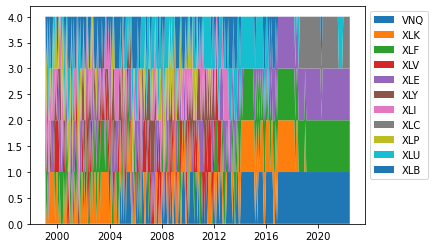

In [25]:
plt.stackplot(ind.index, ind.T.iloc[0], ind.T.iloc[1], ind.T.iloc[2],ind.T.iloc[3],ind.T.iloc[4],ind.T.iloc[5],ind.T.iloc[6],
             ind.T.iloc[7],ind.T.iloc[8],ind.T.iloc[9],ind.T.iloc[10], labels = ind.T.index)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

## Equally weighted portfolio

In [26]:
port1 = np.zeros(len(returns)-1)
port1[0] = 100
bnch = np.zeros(len(returns)-1)
bnch[0] = 100

for i in range(1,len(returns)-1):
    port1[i] = port1[i-1]*np.sum(0.25*(1+returns.iloc[i+1])*ind.iloc[i])
    #print(np.sum((1+returns.iloc[i+1])*ind.iloc[i])/4)
    bnch[i] = np.mean(bnch[i-1]*(1+returns.iloc[i+1]))

port1 = pd.DataFrame(port1).squeeze()
port1.index = ind.index
bnch = pd.DataFrame(bnch).squeeze()
bnch.index = ind.index

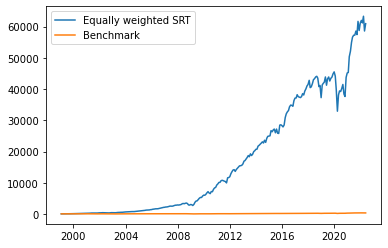

In [27]:
plt.plot(port1)
plt.plot(bnch)
plt.legend(["Equally weighted SRT","Benchmark"])
plt.show()

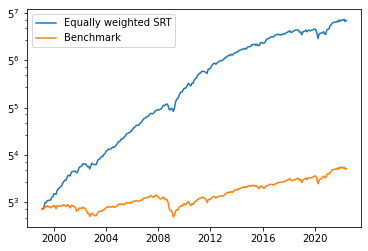

In [28]:
plt.plot(port1)
plt.plot(bnch)
plt.legend(["Equally weighted SRT","Benchmark"])
plt.yscale('log',base=5)
plt.show()

### Performance

In [29]:
ret_port = np.diff(port1)/port1[:-1]
ret_bnch = np.diff(bnch)/bnch[:-1]

In [30]:
print(np.mean(ret_port), np.mean(ret_bnch))

0.024262815037005298 0.00585096510804225


The average return is 2.54% compared to the benchmark of 0.59%.

In [31]:
print(np.std(ret_port), np.std(ret_bnch))

0.047414460412870924 0.043118850614371505


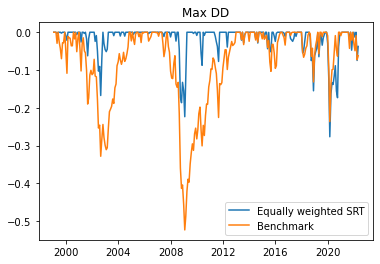

In [32]:
def DD(ret):
  dd = np.zeros(len(ret))
  dd[0] = 0
  for i in range(1,len(ret)):
    dd[i] = min(0,(1+dd[i-1])*(1+ret[i])-1)

  dd = pd.DataFrame(dd).squeeze()
  dd.index = ret.index
  return dd

plt.plot(DD(np.diff(port1)/port1[:-1]), label='Equally weighted SRT')
plt.plot(DD(np.diff(bnch)/bnch[:-1]), label='Benchmark')
plt.legend()
plt.title("Max DD")
plt.show()

In [33]:
print(np.min(DD(np.diff(port1)/port1[:-1])), np.min(DD(np.diff(bnch)/bnch[:-1])))

-0.27650585688444207 -0.5229911488243362


The maximum drawdown is also low, 27.65% compared to benckmark of 52.23%.

For Sharpe ratio, we need to get a risk free rate. I decided to use 3-month treasury bill, which can be found in FRED website.

In [34]:
fred = Fred(api_key='fec003d5c966f4c13258c8476a6b4dba')
tbill3mo = fred.get_series('DGS3MO').dropna()/100/12
tbill3mo

1981-09-01    0.014175
1981-09-02    0.013875
1981-09-03    0.014133
1981-09-04    0.013867
1981-09-08    0.013783
                ...   
2022-08-11    0.002183
2022-08-12    0.002192
2022-08-15    0.002267
2022-08-16    0.002250
2022-08-17    0.002233
Length: 10241, dtype: float64

In [35]:
rf = tbill3mo[port1.index].iloc[:-1]

In [36]:
sharpe_port = np.mean(ret_port-rf) / np.std(ret_port-rf)
sharpe_bnch = np.mean(ret_bnch-rf) / np.std(ret_bnch-rf)
print(sharpe_port,sharpe_bnch)

0.48381633155679243 0.10338546559103308


The sharpe ratio of the portfolio is 0.48, which way outperforms the benchmark of 0.1.

We can also compute information ratio.

In [37]:
info = np.mean(ret_port-ret_bnch)/np.std(ret_port-ret_bnch)
info

0.9268564594186606

The last we want to consider is Calmar ratio.

In [38]:
cal_port = -np.mean(ret_port-rf)/np.min(DD(ret_port))
cal_bnch = -np.mean(ret_bnch-rf)/np.min(DD(ret_bnch))
print(cal_port,cal_bnch)

0.08275911682680659 0.008549916369109798


The Clamar ratios of the portfolio and the benchmark are 0.083 and 0.008, respectively.

## Mean-Variance portfolio

For mean-variance portfolio, we basically will adjust the weights of selected 4 ETF's at each time point. The weight will be given by solving the Markowitz model. I will use the 90-day means and covariances to solve this model.

The following are the returns of each ETF.

In [39]:
table = pd.DataFrame(ETF_list).T
table.columns = [k.upper() for k in name_list]

returns_all = pd.DataFrame.diff(table)/table.shift()
returns_all

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1998-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-12-23,NaN,0.023891,0.014745,0.022472,0.020819,0.004294,0.017450,NaN,0.024175,-0.004191,0.010503
1998-12-24,NaN,-0.003810,0.006605,0.006105,-0.005263,0.018326,0.013193,NaN,-0.001727,0.018411,0.023014
1998-12-28,NaN,0.002868,-0.013123,-0.014563,-0.005291,-0.008998,0.005208,NaN,-0.005767,-0.005165,-0.008708
1998-12-29,NaN,0.002860,0.010638,0.022167,0.009973,0.021792,0.014249,NaN,0.022042,0.016615,0.018302
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-23,0.012549,0.014970,-0.003833,0.022446,-0.037067,0.015710,-0.005101,0.012366,0.019404,0.023540,-0.013680
2022-06-24,0.021277,0.035942,0.036871,0.016602,0.013162,0.038138,0.034957,0.038104,0.019594,0.017396,0.039706
2022-06-27,-0.001503,-0.006744,-0.003401,0.003715,0.029334,-0.010477,-0.002364,-0.009484,-0.002745,0.008115,-0.008240


The following tables shows the means and covariances of the past 90 days price for each ETF.

In [40]:
Mean = returns_all.rolling(90).mean()
start_date = Mean.index[90:]
Mean = Mean.loc[start_date]
Mean = Mean.iloc[extract(xlk['1999-05-04':].index.month)]
Mean

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-05-28,NaN,0.000409,0.000770,0.000235,0.002412,0.000682,0.001724,NaN,-0.000196,-0.000200,0.001586
1999-06-30,NaN,0.001622,0.000849,0.000662,0.002874,0.000835,0.002005,NaN,-0.000484,0.000391,0.002138
1999-07-30,NaN,0.001833,0.000015,0.000445,0.001829,-0.000039,0.001788,NaN,-0.000861,0.001334,0.001934
1999-08-31,NaN,0.001094,-0.001488,-0.001180,0.000953,-0.001422,0.000243,NaN,-0.000598,0.000023,-0.000375
1999-09-30,NaN,0.001416,-0.001304,-0.000610,0.000050,-0.000772,0.000104,NaN,-0.001092,0.000013,-0.001034
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,-0.000005,0.000626,0.000643,0.000006,0.003484,0.000258,0.000229,-0.000938,0.000885,0.000651,0.000645
2022-02-28,-0.000376,-0.000210,-0.000315,0.000140,0.002323,-0.000672,-0.000345,-0.001863,0.000720,0.000388,-0.000088
2022-03-31,-0.000029,-0.000661,-0.000085,0.000381,0.003897,-0.001304,-0.000223,-0.001503,0.000623,0.001176,0.000064


In [41]:
import numpy.ma as ma
Cov = returns_all.rolling(90).cov()
start_date = Cov.index[90*11:]
Cov = Cov.loc[start_date]
dummy = extract(xlk['1999-05-04':].index.month)*11
Cov = Cov.iloc[np.array([k+i for k in dummy for i in range(11)])]
Cov

VNQ       XLK       XLF       XLV       XLE  \
formatted_date                                                         
1999-05-28     VNQ       NaN       NaN       NaN       NaN       NaN   
               XLK       NaN  0.000443  0.000191  0.000186  0.000042   
               XLF       NaN  0.000191  0.000260  0.000154  0.000088   
               XLV       NaN  0.000186  0.000154  0.000186  0.000025   
               XLE       NaN  0.000042  0.000088  0.000025  0.000296   
...                      ...       ...       ...       ...       ...   
2022-05-31     XLI  0.000151  0.000249  0.000179  0.000130  0.000092   
               XLC  0.000189  0.000398  0.000228  0.000157  0.000093   
               XLP  0.000122  0.000147  0.000121  0.000116  0.000049   
               XLU  0.000110  0.000091  0.000069  0.000089  0.000084   
               XLB  0.000167  0.000266  0.000210  0.000152  0.000124   

                         XLY       XLI       XLC       XLP       XLU       XLB  
formatted_date                                                                  
1999-05-28     VNQ       NaN       NaN       NaN       NaN       NaN       NaN  
               XLK  0.000195  0.000063       NaN  0.000171  0.000084 -0.000005  
               XLF  0.000171  0.000079       NaN  0.000130  0.000099  0.000046  
               XLV  0.000144  0.000063       NaN  0.000133  0.000073  0.000024  
               XLE  0.000056  0.000076       NaN  0.000020  0.000066  0.000126  
...                      ...       ...       ...       ...       ...       ...  
2022-05-31     XLI  0.000269  0.000173  0.000207  0.000110  0.000074  0.000181  
               XLC  0.000422  0.000207  0.000429  0.000102  0.000070  0.000229  
               XLP  0.000150  0.000110  0.000102  0.000161  0.000087  0.000119  
               XLU  0.000075  0.000074  0.000070  0.000087  0.000125  0.000081  
               XLB  0.000277  0.000181  0.000229  0.000119  0.000081  0.000235  

[3047 rows x 11 columns]

Now that we have all the inputs needed to solve the model, we will use the ```cvxopt``` package to solve the quadratic optimization problem.

In [42]:
import cvxopt as opt
from cvxopt import blas, solvers
def optimal_portfolio(ret, cov):
    n = len(ret)
    returns = ret
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    #S = opt.matrix(np.cov(returns))
    S = opt.matrix(cov)
    pbar = opt.matrix(returns)
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    solvers.options['show_progress'] = False
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks


In [43]:
returns2 = returns["1999-05-28":]
returns2

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-05-28,NaN,0.003396,-0.060304,-0.030711,-0.021583,-0.045261,-0.019608,NaN,-0.010410,0.011746,-0.091014
1999-06-30,NaN,0.096024,0.040498,0.043913,0.015271,0.063023,0.060000,NaN,0.013614,0.034828,0.054499
1999-07-30,NaN,-0.011579,-0.061078,-0.029819,0.018942,-0.074502,-0.036688,NaN,-0.037241,0.003060,-0.011418
1999-08-31,NaN,0.035143,-0.044005,-0.045005,0.010935,-0.038549,0.008161,NaN,0.017121,-0.047789,-0.044985
1999-09-30,NaN,-0.004149,-0.055370,-0.013793,-0.050297,-0.015920,-0.007016,NaN,-0.092269,0.017619,-0.034373
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,-0.084217,-0.068442,0.000256,-0.068564,0.187748,-0.095334,-0.047916,-0.048018,-0.014784,-0.032551,-0.067984
2022-02-28,-0.034827,-0.048774,-0.013825,-0.009678,0.070692,-0.040660,-0.008438,-0.074375,-0.014085,-0.019061,-0.012670
2022-03-31,0.056856,0.031544,-0.005192,0.054094,0.083026,0.042665,0.030934,0.004821,0.013218,0.096128,0.057208


In [44]:
ind2 = ind["1999-05-28":]
ind2.iloc[65].iloc[0] = 0
ind2.iloc[65].iloc[8] = 1
ind2.iloc[67].iloc[0] = 0
ind2.iloc[67].iloc[8] = 1
ind2.iloc[230].iloc[7] = 0
ind2.iloc[230].iloc[1] = 1
ind2.iloc[231].iloc[7] = 0
ind2.iloc[231].iloc[1] = 1
ind2.iloc[232].iloc[7] = 0
ind2.iloc[232].iloc[1] = 1
ind2

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-05-28,0,1,0,0,0,0,1,0,1,1,0
1999-06-30,0,1,0,0,0,1,1,0,0,0,1
1999-07-30,0,1,0,0,1,0,0,0,0,1,1
1999-08-31,0,1,0,0,1,0,1,0,1,0,0
1999-09-30,0,1,0,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,1,0,1,0,1,0,0,1,0,0,0
2022-02-28,1,0,1,0,1,0,0,1,0,0,0
2022-03-31,1,0,1,0,1,0,0,1,0,0,0


In [45]:
port1 = np.zeros(253)#np.zeros(len(Mean))
port1[0] = 100
bnch = np.zeros(253)
bnch[0] = 100

for i in range(1,253):
    c = Cov.iloc[i*11:i*11+11]
    m = Mean.iloc[i]
    ind3 = ind2.iloc[i]
    print(i,m.iloc[np.where(ind3==True)[0]],np.array(c.iloc[np.where(ind3==True)[0]][ind3.index[np.where(ind3==True)[0]]]))
    weights, ret, risks = optimal_portfolio(m.iloc[np.where(ind3==True)[0]],np.array(c.iloc[np.where(ind3==True)[0]][ind3.index[np.where(ind3==True)[0]]]))
    w = pd.DataFrame(weights).squeeze()
    w.index = (m.iloc[np.where(ind3==True)[0]]).index
    m2 = 1+returns2.iloc[i+1].iloc[np.where(ind3==True)[0]]
    #print(m2,w,np.sum(w*m2))
    #print(i,np.sum(w*m2))
    port1[i] = port1[i-1]*(np.sum(w*m2))
    bnch[i] = np.mean(bnch[i-1]*(1+returns2.iloc[i+1]))

port1 = pd.DataFrame(port1).squeeze()
port1.index = Mean.index[:253]
bnch = pd.DataFrame(bnch).squeeze()
bnch.index = Mean.index[:253]

1 XLK    0.001622
XLY    0.000835
XLI    0.002005
XLB    0.002138
Name: 1999-06-30 00:00:00, dtype: float64 [[ 3.64613398e-04  1.44353639e-04  4.84517938e-05 -1.23790358e-05]
 [ 1.44353639e-04  1.89101473e-04  6.76070395e-05  3.10686337e-05]
 [ 4.84517938e-05  6.76070395e-05  1.10235461e-04  1.02536757e-04]
 [-1.23790358e-05  3.10686337e-05  1.02536757e-04  2.47380963e-04]]
     pcost       dcost       gap    pres   dres
 0: -1.6458e-03 -1.0021e+00  1e+00  2e-16  3e+00
 1: -1.6463e-03 -1.2134e-02  1e-02  6e-17  3e-02
 2: -1.6906e-03 -2.2335e-03  5e-04  8e-17  1e-03
 3: -2.1079e-03 -2.2382e-03  1e-04  2e-16  9e-05
 4: -2.1220e-03 -2.1270e-03  5e-06  1e-16  3e-06
 5: -2.1258e-03 -2.1258e-03  5e-08  3e-16  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6452e-03 -1.0021e+00  1e+00  0e+00  3e+00
 1: -1.6457e-03 -1.2134e-02  1e-02  9e-17  3e-02
 2: -1.6899e-03 -2.2330e-03  5e-04  7e-17  1e-03
 3: -2.1073e-03 -2.2364e-03  1e-04  1e-16  9e-05
 4: -2.1205e-

4 XLK    0.001416
XLY   -0.000772
XLI    0.000104
XLU    0.000013
Name: 1999-09-30 00:00:00, dtype: float64 [[2.66353882e-04 1.22756658e-04 9.26890031e-05 6.48503427e-05]
 [1.22756658e-04 1.60514116e-04 7.87731686e-05 5.60739442e-05]
 [9.26890031e-05 7.87731686e-05 1.00834764e-04 6.06792492e-05]
 [6.48503427e-05 5.60739442e-05 6.06792492e-05 9.77265021e-05]]
5 XLF    0.000322
XLV   -0.000199
XLY    0.000122
XLP    0.000178
Name: 1999-10-29 00:00:00, dtype: float64 [[3.79227761e-04 1.67175509e-04 1.99220038e-04 1.60425920e-04]
 [1.67175509e-04 1.52572419e-04 1.26533448e-04 9.56856808e-05]
 [1.99220038e-04 1.26533448e-04 2.10024937e-04 1.18952670e-04]
 [1.60425920e-04 9.56856808e-05 1.18952670e-04 1.90756025e-04]]
6 XLK    0.001650
XLV   -0.000042
XLI   -0.000767
XLP    0.000023
Name: 1999-11-30 00:00:00, dtype: float64 [[2.52351961e-04 1.33927646e-04 1.14894250e-04 8.67055611e-05]
 [1.33927646e-04 1.61362705e-04 1.11402941e-04 9.73095704e-05]
 [1.14894250e-04 1.11402941e-04 1.45054446e-

30 XLK   -0.000549
XLV   -0.000825
XLY   -0.000473
XLB   -0.000005
Name: 2001-11-30 00:00:00, dtype: float64 [[0.00057413 0.00030759 0.00036645 0.00025068]
 [0.00030759 0.00028393 0.0002885  0.00021073]
 [0.00036645 0.0002885  0.0004067  0.00027342]
 [0.00025068 0.00021073 0.00027342 0.00029947]]
31 XLF   -0.000409
XLE   -0.000951
XLY    0.000481
XLI   -0.000220
Name: 2001-12-31 00:00:00, dtype: float64 [[2.48471808e-04 9.15458787e-05 2.48812929e-04 2.45691780e-04]
 [9.15458787e-05 3.52401080e-04 1.03913611e-04 1.15365198e-04]
 [2.48812929e-04 1.03913611e-04 4.18079851e-04 3.33267313e-04]
 [2.45691780e-04 1.15365198e-04 3.33267313e-04 3.61158946e-04]]
32 XLK    0.003124
XLY    0.003902
XLP    0.000823
XLB    0.002537
Name: 2002-01-31 00:00:00, dtype: float64 [[5.12331287e-04 2.59494476e-04 3.78879074e-05 2.24673026e-04]
 [2.59494476e-04 2.64317903e-04 4.23914694e-05 1.76584907e-04]
 [3.78879074e-05 4.23914694e-05 7.64264629e-05 2.45933168e-05]
 [2.24673026e-04 1.76584907e-04 2.45933168

56 XLK    0.001210
XLF    0.001330
XLV    0.001001
XLE    0.001768
Name: 2004-01-30 00:00:00, dtype: float64 [[1.54594460e-04 6.93569900e-05 4.78400660e-05 3.77758585e-05]
 [6.93569900e-05 5.67328103e-05 3.91745427e-05 2.39214121e-05]
 [4.78400660e-05 3.91745427e-05 6.90558086e-05 2.92150701e-05]
 [3.77758585e-05 2.39214121e-05 2.92150701e-05 7.55344255e-05]]
57 XLE    0.002100
XLY    0.000964
XLP    0.001009
XLB    0.001736
Name: 2004-02-27 00:00:00, dtype: float64 [[7.37479745e-05 1.75509804e-05 1.15998680e-05 2.74284318e-05]
 [1.75509804e-05 5.95360654e-05 2.33632181e-05 4.29373214e-05]
 [1.15998680e-05 2.33632181e-05 2.99004052e-05 1.55904150e-05]
 [2.74284318e-05 4.29373214e-05 1.55904150e-05 8.81222465e-05]]
58 XLF    0.001129
XLE    0.002189
XLY    0.000889
XLP    0.000868
Name: 2004-03-31 00:00:00, dtype: float64 [[5.92817149e-05 4.13868061e-05 5.06023559e-05 3.06827720e-05]
 [4.13868061e-05 1.03706033e-04 3.01955424e-05 2.46016265e-05]
 [5.06023559e-05 3.01955424e-05 6.9489141

79 XLV    0.000203
XLE    0.000643
XLU   -0.000199
XLB    0.001043
Name: 2005-12-30 00:00:00, dtype: float64 [[3.96169002e-05 3.35475449e-05 3.09390975e-05 2.64522752e-05]
 [3.35475449e-05 3.40676414e-04 1.11011041e-04 7.08802637e-05]
 [3.09390975e-05 1.11011041e-04 1.06433457e-04 4.31713281e-05]
 [2.64522752e-05 7.08802637e-05 4.31713281e-05 6.69531562e-05]]
80 VNQ    0.000972
XLE    0.000923
XLU   -0.000162
XLB    0.001876
Name: 2006-01-31 00:00:00, dtype: float64 [[1.08227426e-04 8.43616414e-05 6.19743243e-05 5.52305849e-05]
 [8.43616414e-05 3.49513400e-04 1.22832062e-04 8.47659936e-05]
 [6.19743243e-05 1.22832062e-04 1.07198342e-04 4.16520569e-05]
 [5.52305849e-05 8.47659936e-05 4.16520569e-05 7.35480420e-05]]
81 XLF    0.001390
XLV    0.000634
XLI    0.001103
XLU    0.000701
Name: 2006-02-28 00:00:00, dtype: float64 [[5.92170823e-05 3.16841450e-05 4.00780176e-05 2.97307308e-05]
 [3.16841450e-05 4.48335223e-05 3.17454898e-05 2.78567802e-05]
 [4.00780176e-05 3.17454898e-05 4.5127358

102 XLV    0.000463
XLI   -0.000278
XLP    0.000818
XLU    0.000925
Name: 2007-11-30 00:00:00, dtype: float64 [[8.80208669e-05 9.98884885e-05 6.17559788e-05 8.56855123e-05]
 [9.98884885e-05 1.66861532e-04 8.24906870e-05 1.13035841e-04]
 [6.17559788e-05 8.24906870e-05 6.65702656e-05 7.41331160e-05]
 [8.56855123e-05 1.13035841e-04 7.41331160e-05 1.60800298e-04]]
103 XLK    0.000646
XLE    0.002023
XLU    0.000897
XLB    0.000819
Name: 2007-12-31 00:00:00, dtype: float64 [[1.56802704e-04 1.70103353e-04 6.70532903e-05 1.63741652e-04]
 [1.70103353e-04 3.52412648e-04 1.14515636e-04 2.73149645e-04]
 [6.70532903e-05 1.14515636e-04 1.15009356e-04 1.20521077e-04]
 [1.63741652e-04 2.73149645e-04 1.20521077e-04 2.95433421e-04]]
104 VNQ   -0.001546
XLF   -0.001652
XLV   -0.000512
XLY   -0.001338
Name: 2008-01-31 00:00:00, dtype: float64 [[5.56819797e-04 4.54251700e-04 1.22857724e-04 2.64222635e-04]
 [4.54251700e-04 5.14868963e-04 1.45250106e-04 2.79580082e-04]
 [1.22857724e-04 1.45250106e-04 1.0231

128 XLF   -0.000472
XLV    0.000864
XLI    0.000298
XLP    0.000399
Name: 2010-01-29 00:00:00, dtype: float64 [[3.08280919e-04 1.00605829e-04 1.80589569e-04 6.55202721e-05]
 [1.00605829e-04 7.72010490e-05 8.22898805e-05 3.92066623e-05]
 [1.80589569e-04 8.22898805e-05 1.63593634e-04 5.57426728e-05]
 [6.55202721e-05 3.92066623e-05 5.57426728e-05 3.90571777e-05]]
129 VNQ    0.001156
XLK    0.000356
XLY    0.000889
XLP    0.000299
Name: 2010-02-26 00:00:00, dtype: float64 [[2.99377804e-04 1.31104760e-04 1.46271757e-04 7.10929012e-05]
 [1.31104760e-04 1.21742552e-04 9.98407827e-05 5.35181131e-05]
 [1.46271757e-04 9.98407827e-05 1.23479247e-04 5.89549527e-05]
 [7.10929012e-05 5.35181131e-05 5.89549527e-05 4.81897566e-05]]
130 VNQ    0.001473
XLY    0.001355
XLI    0.001298
XLB    0.000390
Name: 2010-03-31 00:00:00, dtype: float64 [[1.92095107e-04 8.63419019e-05 9.90396156e-05 1.28811149e-04]
 [8.63419019e-05 7.57140586e-05 7.71680131e-05 9.31236664e-05]
 [9.90396156e-05 7.71680131e-05 1.0711

153 XLK    0.001566
XLF    0.001934
XLV    0.001253
XLE    0.001421
Name: 2012-02-29 00:00:00, dtype: float64 [[0.00015361 0.00021148 0.00011382 0.00018978]
 [0.00021148 0.00037144 0.00017861 0.00029629]
 [0.00011382 0.00017861 0.00011546 0.00015767]
 [0.00018978 0.00029629 0.00015767 0.00030335]]
154 VNQ    0.001609
XLF    0.002715
XLV    0.001539
XLI    0.001496
Name: 2012-03-30 00:00:00, dtype: float64 [[1.29602574e-04 1.39670510e-04 7.32849041e-05 1.07719009e-04]
 [1.39670510e-04 2.21680953e-04 9.84888902e-05 1.61049309e-04]
 [7.32849041e-05 9.84888902e-05 7.05172419e-05 8.90502238e-05]
 [1.07719009e-04 1.61049309e-04 8.90502238e-05 1.46025521e-04]]
155 VNQ    0.001765
XLV    0.001306
XLU    0.000459
XLB    0.001593
Name: 2012-04-30 00:00:00, dtype: float64 [[8.00872997e-05 3.72952200e-05 2.80301618e-05 6.38182738e-05]
 [3.72952200e-05 3.89734379e-05 1.92213149e-05 5.53026813e-05]
 [2.80301618e-05 1.92213149e-05 4.10570586e-05 2.50878107e-05]
 [6.38182738e-05 5.53026813e-05 2.50878

176 VNQ    0.000088
XLK    0.000787
XLF    0.000534
XLU    0.000348
Name: 2014-01-31 00:00:00, dtype: float64 [[7.49017012e-05 3.23030755e-05 4.52309157e-05 3.92519011e-05]
 [3.23030755e-05 4.85400180e-05 4.18692085e-05 2.31141410e-05]
 [4.52309157e-05 4.18692085e-05 7.70951365e-05 3.21707430e-05]
 [3.92519011e-05 2.31141410e-05 3.21707430e-05 5.13952517e-05]]
177 VNQ    0.000167
XLK    0.001017
XLE    0.000125
XLU    0.000592
Name: 2014-02-28 00:00:00, dtype: float64 [[5.86684074e-05 2.51858125e-05 2.79575191e-05 3.18287550e-05]
 [2.51858125e-05 4.54626689e-05 3.74923358e-05 2.20376395e-05]
 [2.79575191e-05 3.74923358e-05 6.89717313e-05 2.98108858e-05]
 [3.18287550e-05 2.20376395e-05 2.98108858e-05 4.58868468e-05]]
178 VNQ    0.000594
XLK    0.000714
XLF    0.000661
XLU    0.000612
Name: 2014-03-31 00:00:00, dtype: float64 [[5.85362997e-05 2.95764192e-05 3.59055799e-05 2.96202027e-05]
 [2.95764192e-05 5.31955809e-05 4.68617661e-05 2.19600860e-05]
 [3.59055799e-05 4.68617661e-05 7.4909

199 VNQ    0.000815
XLK    0.001413
XLF    0.000662
XLU    0.000044
Name: 2015-12-31 00:00:00, dtype: float64 [[1.28463037e-04 9.60858455e-05 1.04950421e-04 9.52217615e-05]
 [9.60858455e-05 1.69002814e-04 1.55094283e-04 8.10066877e-05]
 [1.04950421e-04 1.55094283e-04 1.77239307e-04 8.69632994e-05]
 [9.52217615e-05 8.10066877e-05 8.69632994e-05 1.29200071e-04]]
200 VNQ    0.000069
XLK    0.000292
XLE   -0.000745
XLU    0.000820
Name: 2016-01-29 00:00:00, dtype: float64 [[1.28554152e-04 8.92032259e-05 1.03254395e-04 7.63020094e-05]
 [8.92032259e-05 1.62085455e-04 1.73682910e-04 6.58539292e-05]
 [1.03254395e-04 1.73682910e-04 4.34184799e-04 1.00527411e-04]
 [7.63020094e-05 6.58539292e-05 1.00527411e-04 1.11135143e-04]]
201 VNQ   -0.000552
XLK   -0.000225
XLU    0.000421
XLB   -0.000400
Name: 2016-02-29 00:00:00, dtype: float64 [[1.42336719e-04 9.85384886e-05 7.57066824e-05 8.54151309e-05]
 [9.85384886e-05 1.72564201e-04 5.39271820e-05 1.35382959e-04]
 [7.57066824e-05 5.39271820e-05 1.1541

222 VNQ    0.000108
XLK    0.001187
XLF    0.000998
XLE    0.000566
Name: 2017-11-30 00:00:00, dtype: float64 [[ 3.32747390e-05  9.87708379e-06 -1.33117349e-06  5.74226668e-06]
 [ 9.87708379e-06  4.97463329e-05  1.73219557e-05  7.77279126e-06]
 [-1.33117349e-06  1.73219557e-05  5.65114374e-05  1.35127627e-05]
 [ 5.74226668e-06  7.77279126e-06  1.35127627e-05  4.75433597e-05]]
223 VNQ    0.000039
XLK    0.001125
XLF    0.001330
XLE    0.001654
Name: 2017-12-29 00:00:00, dtype: float64 [[ 3.81630457e-05  8.39434491e-06 -5.34751760e-06 -4.30423685e-07]
 [ 8.39434491e-06  4.17445133e-05  4.41856326e-06  1.21236263e-06]
 [-5.34751760e-06  4.41856326e-06  5.24139271e-05  9.21393216e-06]
 [-4.30423685e-07  1.21236263e-06  9.21393216e-06  4.88347045e-05]]
224 VNQ   -0.000584
XLK    0.001773
XLF    0.001749
XLE    0.001288
Name: 2018-01-31 00:00:00, dtype: float64 [[ 5.03744425e-05  1.26897883e-05 -4.63706312e-06  3.48489772e-06]
 [ 1.26897883e-05  4.85855873e-05  5.58798089e-06  1.40748827e-05

246 VNQ    0.000597
XLF    0.000655
XLE   -0.000742
XLC    0.000521
Name: 2019-11-29 00:00:00, dtype: float64 [[5.25253656e-05 3.29074802e-05 2.71954490e-05 3.61308261e-05]
 [3.29074802e-05 1.21328721e-04 1.09806817e-04 9.73710171e-05]
 [2.71954490e-05 1.09806817e-04 1.88502725e-04 9.12405657e-05]
 [3.61308261e-05 9.73710171e-05 9.12405657e-05 1.14030465e-04]]
247 VNQ    0.000119
XLF    0.001584
XLE    0.000481
XLC    0.000979
Name: 2019-12-31 00:00:00, dtype: float64 [[4.51666921e-05 6.67226016e-06 1.55083803e-06 1.58575471e-05]
 [6.67226016e-06 7.18799973e-05 6.99534935e-05 5.01443509e-05]
 [1.55083803e-06 6.99534935e-05 1.56342359e-04 5.31816369e-05]
 [1.58575471e-05 5.01443509e-05 5.31816369e-05 6.52436459e-05]]
248 VNQ    0.000062
XLF    0.000734
XLE   -0.001452
XLC    0.000754
Name: 2020-01-31 00:00:00, dtype: float64 [[ 4.56120467e-05  7.44293617e-06 -1.08853000e-06  1.38923416e-05]
 [ 7.44293617e-06  6.84442744e-05  6.75674736e-05  4.28878960e-05]
 [-1.08853000e-06  6.75674736e

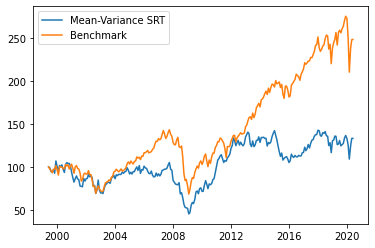

In [46]:
plt.plot(port1)
plt.plot(bnch)
plt.legend(["Mean-Variance SRT","Benchmark"])
plt.show()

### Performance

In [47]:
ret_port = np.diff(port1)/port1[:-1]
ret_bnch = np.diff(bnch)/bnch[:-1]

In [48]:
print(np.mean(ret_port), np.mean(ret_bnch))

0.0024532781191819284 0.004561304686898108


The average return is 0.24% compared to the benchmark of 0.45%.

In [49]:
print(np.std(ret_port), np.std(ret_bnch))

0.051299703971026726 0.04309445210215032


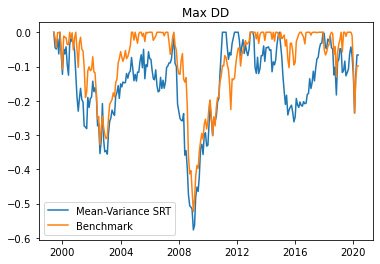

In [50]:
def DD(ret):
  dd = np.zeros(len(ret))
  dd[0] = 0
  for i in range(1,len(ret)):
    dd[i] = min(0,(1+dd[i-1])*(1+ret[i])-1)

  dd = pd.DataFrame(dd).squeeze()
  dd.index = ret.index
  return dd

plt.plot(DD(np.diff(port1)/port1[:-1]), label='Mean-Variance SRT')
plt.plot(DD(np.diff(bnch)/bnch[:-1]), label='Benchmark')
plt.legend()
plt.title("Max DD")
plt.show()

In [51]:
print(np.min(DD(np.diff(port1)/port1[:-1])), np.min(DD(np.diff(bnch)/bnch[:-1])))

-0.5767503965580107 -0.522991148824336


The maximum drawdown is also low, 57.67% compared to benckmark of 52.29%.

Sharpe ratio

In [52]:
sharpe_port = np.mean(ret_port-rf) / np.std(ret_port-rf)
sharpe_bnch = np.mean(ret_bnch-rf) / np.std(ret_bnch-rf)
print(sharpe_port,sharpe_bnch)

0.019259728137539702 0.07171165872024007


The sharpe ratio of the portfolio is 0.02, which way outperforms the benchmark of 0.07.

We can also compute information ratio.

In [53]:
info = np.mean(ret_port-ret_bnch)/np.std(ret_port-ret_bnch)
info

-0.05995370166092455

The last we want to consider is Calmar ratio.

In [54]:
cal_port = -np.mean(ret_port-rf)/np.min(DD(ret_port))
cal_bnch = -np.mean(ret_bnch-rf)/np.min(DD(ret_bnch))
print(cal_port,cal_bnch)

0.001719296327625344 0.005926737791724926


The Clamar ratios of the portfolio and the benchmark are 0.0017 and 0.006, respectively.